In [1]:
%matplotlib inline

In [2]:
import requests
import netCDF4
import matplotlib.pyplot as plt
from pprint import pprint
try:
    import lxml.etree as ET
except:
    import xml.etree.ElementTree as ET

In [3]:
#Set NCSS endpoint, bounding box and netCDF file output path
ncss_endpoint = 'http://dap-wms.nci.org.au/thredds/ncss/rr2/geophysics/magmap_v6_2015_VRTP/magmap_v6_2015_VRTP.nc'
bbox_list = [141.77, -37.69, 142.20, -37.36]
nc_output_path = 'C:/Temp/ncss_test.nc'

In [4]:
# Define function to read netCDf subset and write to netCDF file and return variable_details_list
def get_netcdf_subset(ncss_endpoint, bbox_list, nc_output_path):
    '''
    Function to read netCDf subset and write to netCDF file and return variable_details_list
    See the following page for details:
    https://www.unidata.ucar.edu/software/thredds/current/tds/reference/NetcdfSubsetServiceReference.html
    '''
    # Get dataset description XML
    response = requests.get(ncss_endpoint + '/dataset.xml')
    dataset_description = ET.fromstring(response.content)
    #print(response.content)
    
    # Read variable details from dataset description XML tree
    # N.B: This is a bit of a hack which will fail if there are multiple grid resolutions in the one dataset, 
    # but it's OK when there's only one
    variable_details_list = [grid_element.attrib for grid_element in dataset_description.findall('.//grid')]
    #pprint(variable_details)
    
    # Setup request parameters
    query_params = {'var': ','.join([variable_details['name'] 
                                 for variable_details in variable_details_list]),
                    'west': bbox_list[0],
                    'east': bbox_list[2],
                    'south': bbox_list[1],
                    'north': bbox_list[3],
                    }
    
    response = requests.get(ncss_endpoint, params=query_params, stream=True)
    assert response.status_code == 200, 'Request failed with response code {}'.format(response.status_code)
    
    with open(nc_output_path, 'wb') as nc_file:
        for chunk in response:
            nc_file.write(chunk)

    return variable_details_list

In [5]:
# Retrieve subset and write to file
variable_details_list = get_netcdf_subset(ncss_endpoint, bbox_list, nc_output_path)

In [6]:
# Open file for reading
netcdf_dataset = netCDF4.Dataset(nc_output_path, 'r')
netcdf_dataset.__dict__

OrderedDict([(u'_NCProperties',
              u'version=1|netcdflibversion=4.4.1|hdf5libversion=1.8.18'),
             (u'GDAL', u'GDAL 1.11.1, released 2014/09/24'),
             (u'geospatial_lon_min', 141.769604069),
             (u'geospatial_lon_resolution', 0.00083333),
             (u'geospatial_lat_max', -37.360233833),
             (u'geospatial_bounds_crs',
              u'GEOGCS["WGS 84",\n    DATUM["WGS_1984",\n        SPHEROID["WGS 84",6378137,298.257223563,\n            AUTHORITY["EPSG","7030"]],\n        AUTHORITY["EPSG","6326"]],\n    PRIMEM["Greenwich",0,\n        AUTHORITY["EPSG","8901"]],\n    UNIT["degree",0.0174532925199433,\n        AUTHORITY["EPSG","9122"]],\n    AUTHORITY["EPSG","4326"]]'),
             (u'geospatial_lat_min', -37.690233701000004),
             (u'geospatial_lat_resolution', 0.00083333),
             (u'geospatial_lat_units', u'degrees'),
             (u'geospatial_lon_units', u'degrees'),
             (u'geospatial_bounds',
              u'POLY

mag_tmi_rtp_anomaly has shape (397, 517)


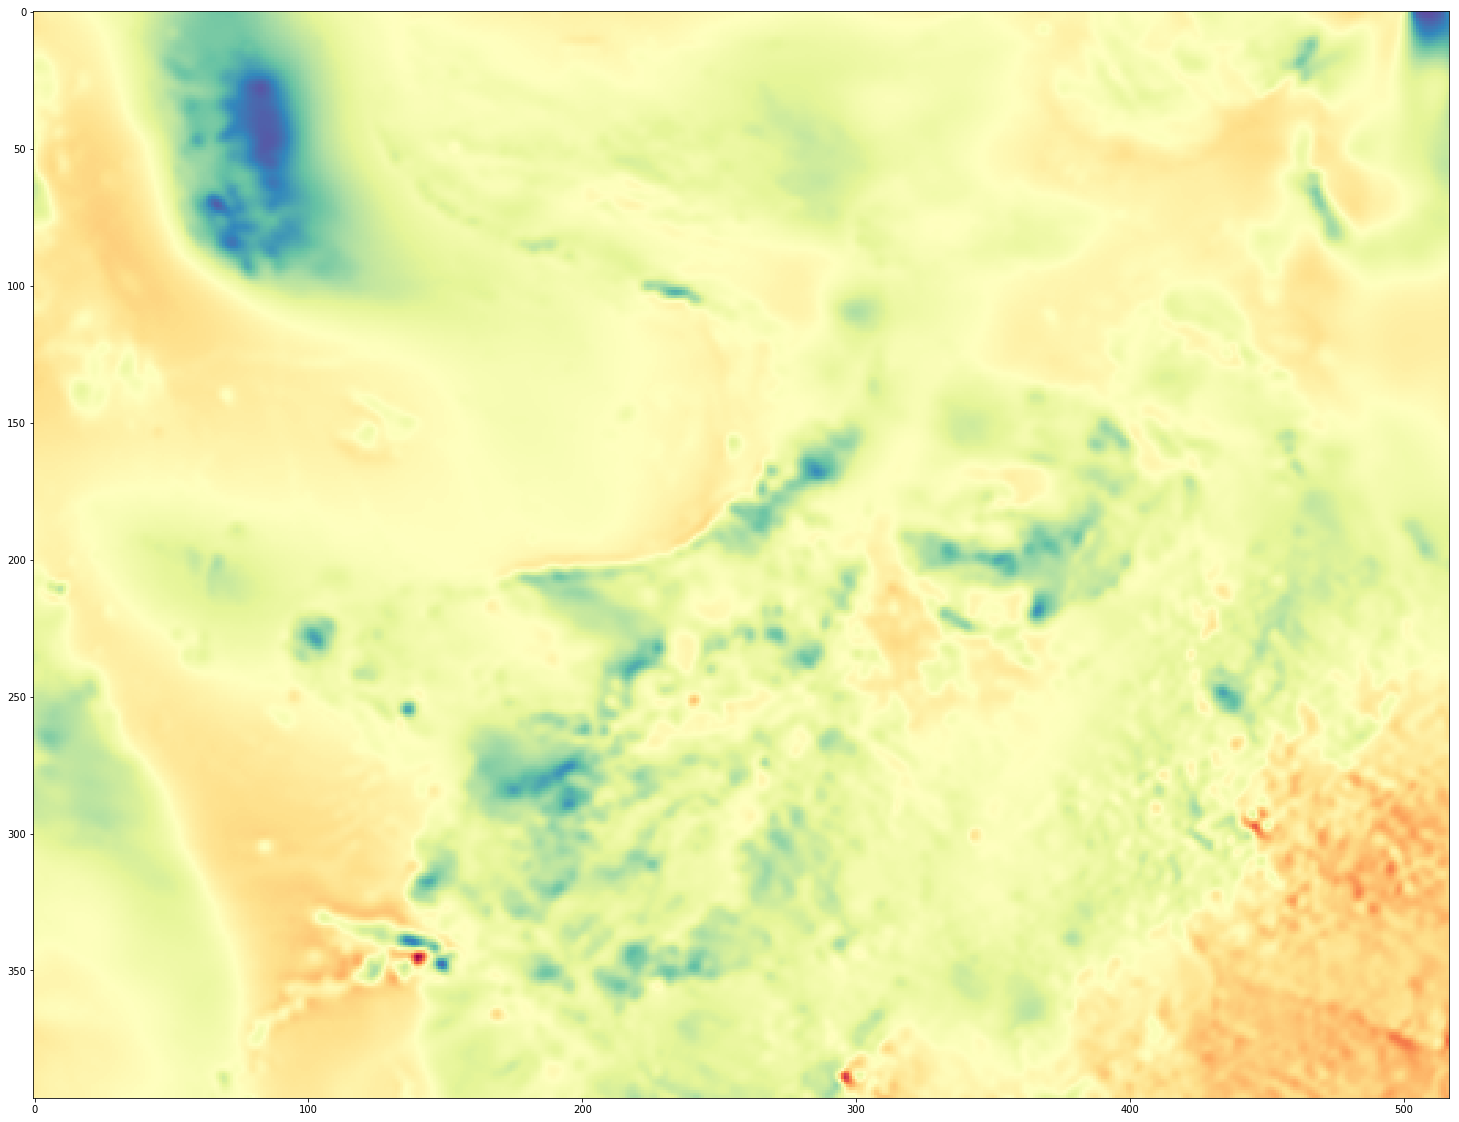

In [7]:
#Plot first (and only) grid variable
variable_name = variable_details_list[0]['name']
print('{} has shape {}'.format(variable_name, netcdf_dataset.variables[variable_name].shape))

plt.figure(figsize=(30,20))
plt.imshow(netcdf_dataset.variables[variable_name], cmap='Spectral')